In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool
sys.path.append('..')
import loaders
import data

import warnings
from lightkurve import LightkurveWarning
warnings.filterwarnings("ignore", category=LightkurveWarning)



SEED = 12345
%load_ext autoreload
%autoreload 2

In [3]:
### Uncomment to mount the drive and/or bucket

# lcs stored on drive for quick access
# data.mount_drive('/mnt/disks/lcs/')

# other data products stored on google bucket
# !gcsfuse --implicit-dirs tess-goddard-lcs /home/jupyter/mountpoint

# Features

In [4]:
from extern import features

In [10]:
fluxes = pd.read_csv("subplot_data/Triangle_depth.csv")
fluxes

,Flux1,Flux2,Flux3,Flux4,Flux5,Flux6,Time,Depths,Mstats
0,1.012746,1.012746,1.012746,1.012746,1.012746,1.012746,0.000000,0.554982,1.452117
1,1.011068,1.011068,1.011068,1.011068,1.011068,1.011068,0.020833,0.624619,1.442529
2,1.013019,1.013019,1.013019,1.013019,1.013019,1.013019,0.041666,0.709328,1.420603
3,1.012968,1.012968,1.012968,1.012968,1.012968,1.012968,0.062500,0.808649,1.368323
4,1.010584,1.010584,1.010584,1.010584,1.010584,1.010584,0.083333,0.910425,1.220132
...,...,...,...,...,...,...,...,...,...
879,1.000188,1.000188,1.000188,1.000188,1.000188,1.000188,22.770410,NaN,NaN
880,0.998662,0.998662,0.998662,0.998662,0.998662,0.998662,22.791242,NaN,NaN
881,0.998772,0.998772,0.998772,0.998772,0.998772,0.998772,22.812075,NaN,NaN
882,0.995496,0.995496,0.995496,0.995496,0.995496,0.995496,22.832908,NaN,NaN


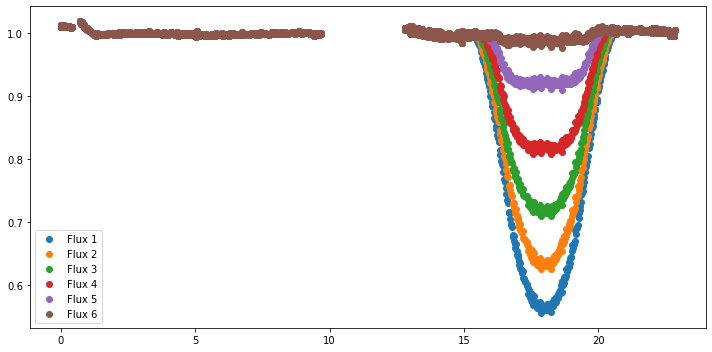

In [11]:
fig, ax = plt.subplots(1, figsize=(10,5), tight_layout=True)
for i in range(1,7):
    ax.scatter(fluxes['Time'], fluxes[f'Flux{i}'], label=f"Flux {i}")
plt.legend();

*index*
## Testing 1 light curve

In [12]:
test_time = fluxes["Time"].values
test_flux = fluxes["Flux1"].values
test_err = np.zeros_like(test_flux)

test_features = features.feats(test_time, test_flux, test_err)

test_features = pd.DataFrame(columns=test_features.keys(), data=[test_features.values()])

mstat = features.calc_mstat(test_flux)

test_features['mstat'] = mstat

test_features

,stds,meanmedrat,varss,coeffvar,numout1s,numposoutliers,numnegoutliers,numoutliers,mad,meanpslope,...,sautocorrcoef,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,mstat
0,0.139901,0.930498,0.019572,0.1505,149.0,0.0,0.0,0.0,0.003346,0.147617,...,-0.193574,0.75905,0.004998,0.011488,0.067653,0.477797,0.861777,0.444468,0.046189,1.441


### Doing more light curves

In [13]:
test_feats = pd.DataFrame()
for i in range(1, 7):
    test_time = fluxes["Time"].values
    test_flux = fluxes[f"Flux{i}"].values
    test_err = np.zeros_like(test_flux, dtype=np.uint8)
    
    test_features = features.feats(test_time,
                                   test_flux,
                                   test_err)  # returns dict of features
    
    test_features = pd.DataFrame(index=[i],
                                 columns=test_features.keys(),
                                 data=[test_features.values()])
    
    mstat = features.calc_mstat(test_flux)
    test_features['mstat'] = mstat
    test_feats = test_feats.append(test_features)

In [14]:
test_feats

,stds,meanmedrat,varss,coeffvar,numout1s,numposoutliers,numnegoutliers,numoutliers,mad,meanpslope,...,sautocorrcoef,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,mstat
1,0.139901,0.930498,0.019572,0.150500,149.0,0.0,0.0,0.0,0.003346,0.147617,...,-0.193574,0.759050,0.004998,0.011488,0.067653,0.477797,0.861777,0.444468,0.046189,1.441
2,0.117370,0.942454,0.013776,0.124657,149.0,0.0,0.0,0.0,0.003303,0.144267,...,-0.268404,0.765837,0.005875,0.013233,0.048224,0.476849,0.856142,0.374781,0.054533,1.431
3,0.091913,0.955681,0.008448,0.096262,150.0,0.0,0.0,0.0,0.003163,0.142238,...,-0.348096,0.770362,0.007216,0.015707,0.039417,0.483723,0.869943,0.290032,0.069960,1.410
4,0.062040,0.970937,0.003849,0.063952,152.0,0.0,0.0,0.0,0.003045,0.139278,...,-0.428724,0.778281,0.010387,0.021446,0.047574,0.510117,0.913757,0.190656,0.103940,1.358
5,0.028657,0.987673,0.000821,0.029036,157.0,0.0,0.0,0.0,0.002884,0.135576,...,-0.497068,0.745475,0.022004,0.040646,0.083977,0.568611,0.913104,0.088915,0.211928,1.209
6,0.006137,0.999163,0.000038,0.006145,244.0,0.0,0.0,0.0,0.002579,0.133043,...,-0.524939,0.535068,0.079489,0.156459,0.260064,0.463259,0.761010,0.021845,0.679793,0.296


# Scoring

<a id="Scoring"></a>

In [15]:
feats = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/db.v2.h5", "S18/features")
sector_scores = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/s18rescore.h5", "S18/scores")

In [16]:
def get_subset(s):
    """Returns the subset features used to rescore a sector.
    
    Note: only Sector 18 has been rescored and had the reference subset
    saved as of 7/7/2023. 
    """
    try:
        df = feats  # if feats is defined in an earlier block
    except:
        datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
        df = pd.read_hdf(datafile, f"S{s}/features")

    subset_tics = np.loadtxt(f"/home/jupyter/mountpoint/dataproducts/s{s}_score_reference.txt")
    sample_subset = df.loc[subset_tics]
    return sample_subset

from sklearn import preprocessing

def data_scaler(data_to_scale, s=18):
    """Scales given features by the same factors as the given sector.
    
    This method recalculates the factors needed to scale each feature for a
    given sector. The features are scaled and shifted such that each set of
    features has a mean of zero and a standard deviation of one for
    the features calculated for all light curves in the given sector.
    
    Though possible, newly scaled data should not be expected to have a mean
    of zero or a standard a deviation of one for any feature.
    """
    try:
        df = feats.iloc[:, 0:61]
    except: 
        datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
        df = pd.read_hdf(datafile, f"S{s}/features")[:, 0:61]  # including mstat but not astat

    scaler = preprocessing.StandardScaler().fit(df)
    scaled = scaler.transform(data_to_scale)
    scaled = pd.DataFrame(index=data_to_scale.index,
                                columns=df.columns,
                                data=scaled)
    return scaled

def score_scaler(score):
    """Rescales "raw" scores to match Sector 18 rescored
    
    Calculated based on reference points. Not perfect, but pretty good
    Note: can't do similar to data_scaler because "raw" scores aren't saved
    """
    factor = 0.00018255470902209855
    offset = -4.34047914797675e-12
    scaled = score*factor+offset
    return scaled

def dist_scores(ref_data, d2s=None, k=1, scaler=False):
    """
    This method calculates the distance to the k-th neighbor in the reference data
    Args:
        ref_data (Numpy array or Pandas dataframe) - The reference data to which
            distances will be calculated
        d2s (Numpy array or Pandas dataframe) - Data to be scored (if None,
            same as the reference data)
        k (integer) - neighbor to calculate the distance

    Returns:
        scores (Numpy array) - distances for data in d2s.
    """


    if isinstance(d2s, type(None)):
        # if d2s is a dataframe, the evaluation of d2s==None tries to compare
        # every value of the dataframe to None, instead we check if it's
        # NoneType
        d2s = ref_data  # will default to full data if d2s is not specified

    if isinstance(scaler, type(data_scaler)):
        ref_data = scaler(ref_data)
        d2s = scaler(d2s)
    nbrs = NearestNeighbors(
        n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1).fit(ref_data)
    distances, indices = nbrs.kneighbors(d2s)

    scores = score_scaler(distances[:, k])

    return scores

In [17]:
sample_subset = get_subset(18).iloc[:,:61]

In [18]:
to_score = test_feats

In [20]:
scores = dist_scores(sample_subset, to_score, k=1, scaler=data_scaler)
scores_df = pd.DataFrame(data=scores.T, columns=["scores"])
# scores_df['rank'] = scores_df.rank(ascending=False).scores.values
scores_df["TIC_ID"] = scaled_feats.index
print(scores_df)
# del(ref, df, scaled_feats, scores)
# gc.collect()

     scores
0  0.001440
1  0.001406
2  0.001329
3  0.001275
4  0.001150
5  0.000614


In [ ]:
test_ranks = [sector_scores[sector_scores.scores>scores[i]]['rank'].max()+1 for i in scores_df.index]
scores_df['ranks'] = test_ranks

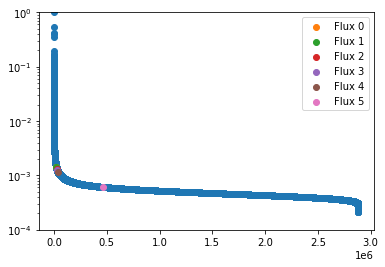

In [404]:
fig, ax = plt.subplots(1)
ax.scatter(sector_scores['rank'], sector_scores.scores)
for index, row in scores_df.iterrows():
    ax.scatter(row.ranks, row.scores,
               label=f"Flux {index}")
ax.set_yscale('log')
ax.set_ylim(1E-4, 1E0)
plt.legend();

# Appendix: Scaling distances -> scores

In [65]:
scores_df["TIC_ID"] = sample_subset.index.astype(int)

In [75]:
refpoints = sector_scores[sector_scores.TIC_ID.isin(scores_df.head(2).TIC_ID)].reset_index()

In [69]:
scores_df.head(2)

,scores,TIC_ID
0,2.317967,468603196
1,2.774197,428047465


In [76]:
refpoints

,index,scores,rank,TIC_ID
0,224696,0.000423,2131928.5,468603196
1,2711288,0.000506,1164110.5,428047465


In [89]:
diff_abs = scores_df.head(2).loc[1, 'scores']-scores_df.head(2).loc[0, 'scores']

dif_scaled = refpoints.loc[1,'scores']-refpoints.loc[0,'scores']

factor = dif_scaled/diff_abs

offset = refpoints.loc[1,'scores']-factor*scores_df.head(2).loc[1, 'scores']

In [108]:
print(f"score = {factor:.3E} * distance + {offset:.3E}")

score = 1.826E-04 * distance + -4.340E-12


# Features from Dana

Dana sent these features for a circular occulter of varying depths on July 5th

These features were scaled by appending the "raw" features to the sector features
and then using StandardScaler. 

We have since revised the scaling to the methodology above, see the details
in the `data_scaler` method in the [Scoring](#Scoring) section

In [155]:

dana_feats = pd.read_csv('features.csv', index_col=0)

In [156]:
dana_feats

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat
0,-0.038648,-3.004007,-0.002312,0.670674,-1.443715,-0.818716,-1.056042,-2.073595,-0.801077,52.889459,...,1.054927,-3.153488,27.933755,-3.154007,-3.581431,-9.641357,-6.343687,-0.242513,-0.011481,2.969746
0,-0.037302,-2.773761,-0.002326,0.555128,-1.444045,-0.821796,-1.056042,-2.073595,-0.801077,52.529519,...,1.061223,-3.459923,27.933253,-3.189573,-3.681924,-6.530074,-9.698340,0.009306,-0.009317,2.971843
0,-0.035795,-2.514535,-0.002331,0.428655,-1.444422,-0.825432,-1.056042,-2.073595,-0.801077,52.529519,...,1.070910,-3.824448,27.932483,-3.177241,-3.644789,-12.009994,-11.138844,0.044431,-0.010243,2.971843
0,-0.034245,-2.252057,-0.002332,0.307559,-1.444805,-0.829245,-1.056042,-2.073595,-0.801077,52.529519,...,1.082910,-4.196975,27.931366,-3.199446,-3.781131,-12.892363,-12.937714,0.032923,-0.005058,2.965551
0,-0.032597,-1.971277,-0.002329,0.187587,-1.445214,-0.833456,-1.056042,-2.073595,-0.801077,52.169572,...,1.098510,-4.617115,27.929663,-3.108024,-3.778402,-13.870203,-17.456512,0.017720,-0.002189,2.950872
0,-0.030904,-1.684874,-0.002324,0.077724,-1.445626,-0.837852,-1.056042,-2.073595,-0.801077,52.529519,...,1.119573,-5.059847,27.927011,-3.128701,-3.689260,-13.418402,-12.315431,0.040936,-0.007457,2.929900
0,-0.029096,-1.379610,-0.002316,-0.023947,-1.446061,-0.842634,-1.056042,-2.073595,-0.801077,52.889459,...,1.150755,-5.541438,27.922325,-3.029621,-3.667469,-8.505616,-9.129785,0.043129,-0.005832,2.890055
0,-0.027321,-1.078472,-0.002307,-0.108019,-1.446487,-0.847480,-1.056042,-2.073595,-0.801077,53.609317,...,1.197031,-6.009206,27.913521,-3.031448,-3.713551,-13.742986,-9.625616,0.095700,-0.003710,2.831335
0,-0.025428,-0.757826,-0.002294,-0.177555,-1.446934,-0.852731,-1.056042,-2.073595,-0.801077,54.329146,...,1.282367,-6.473929,27.891649,-3.002039,-3.643184,-14.296462,-8.237313,0.225231,-0.006155,2.728576
0,-0.023481,-0.427157,-0.002270,-0.226636,-1.447391,-0.858275,-1.056042,-2.073595,-0.801077,54.689049,...,1.478782,-6.905318,27.808925,-3.002741,-3.704725,-14.659469,-5.011409,-0.164874,-0.003383,2.554514


In [182]:
plt.cm.tab20(1)

(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)

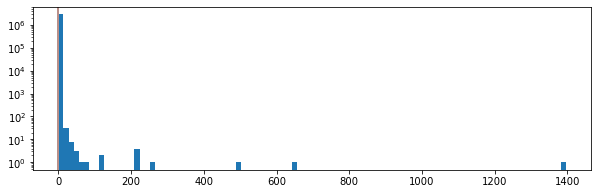

In [183]:
fig, ax = plt.subplots(1, figsize=(10,3))
ax.hist(feats['longtermtrend'], bins=100)
ax.set_yscale('log')
colors = plt.cm.tab20
for index, row in dana_feats.iterrows():
    ax.axvline(row['longtermtrend'], c=colors(index))

In [157]:
dana_feats.reset_index(inplace=True)

In [186]:
import ipywidgets as widgets


In [213]:
colors = plt.cm.tab20
out = [widgets.Output() for i in range(61)]
for i, col in enumerate(scaled_feats.columns):
    with out[i]:
        fig, ax = plt.subplots(figsize=(10,3))
        ax.hist(feats[col], bins=100)
        ax.set_yscale('log')
        for index, row in dana_feats.iterrows():
            ax.axvline(row[col], c=colors(index), label=str(index))
        plt.legend()
        plt.show(fig);

accordion = widgets.Accordion(children=out)
for i, col in enumerate(scaled_feats.columns):
    accordion.set_title(i, col)

accordion

Accordion(children=(Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), …

In [ ]:

data1 = pd.DataFrame(np.random.normal(size = 50))
data2 = pd.DataFrame(np.random.normal(size = 100))

tab = widgets.Tab(children = [out1, out2])

with out1:
    fig1, axes1 = plt.subplots()
    data1.hist(ax = axes1)
    plt.show(fig1)

with out2:
    fig2, axes2 = plt.subplots()
    data2.hist(ax = axes2)
    plt.show(fig2)

In [212]:
sample_subset[sample_subset.mstat>1]

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat
285235649.0,-0.013287,-0.021471,-0.000860,-0.153234,-0.624692,-0.866391,3.044803,2.456280,-0.271570,-0.024462,...,-0.673776,0.595803,0.434412,0.389302,0.572813,0.691714,0.897328,-0.007458,-0.020944,1.445133
264917764.0,0.007333,-0.112552,-0.000860,0.123600,-0.792151,-0.866391,1.848723,1.135066,0.287761,-0.028767,...,-0.010523,0.974123,-0.976429,-1.193314,-1.385245,-1.370265,-1.159348,-0.000731,-0.022819,1.805840
399197356.0,-0.005908,-0.041689,-0.000860,-0.054560,-0.834016,-0.866391,0.652643,-0.186148,0.103090,0.004614,...,-0.567823,0.384883,0.394365,0.538135,0.572558,0.441315,0.402551,-0.002931,-0.021469,1.411579
302160351.0,0.004762,-0.091962,-0.000860,0.088801,-0.875881,-0.866391,1.165248,0.380086,0.551015,0.009262,...,-0.431753,0.788069,0.182382,0.064610,0.039915,0.108927,0.366805,-0.000460,-0.022599,1.556281
245708634.0,0.010927,-0.115781,-0.000860,0.171838,-0.903791,-0.866391,1.506986,0.757576,0.603323,-0.001238,...,-0.345357,1.106160,0.272917,-0.101008,-0.375854,-0.239613,-0.285899,0.000926,-0.022898,1.682109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240749837.0,0.004683,-0.046843,-0.000860,0.086998,-1.154980,-0.866391,0.481774,-0.374893,-0.087048,0.007862,...,0.563771,1.042794,-0.089431,0.076254,-0.133506,-0.139666,0.327547,0.003962,-0.020957,1.042483
307119722.0,0.012946,-0.088132,-0.000859,0.198313,-1.113115,-0.866391,0.823511,0.002596,-0.171594,-0.030723,...,1.978860,1.278735,-0.904617,-0.940385,-0.897828,-0.854458,-0.839557,0.005746,-0.023223,1.281556
233046115.0,0.033149,-0.130205,-0.000858,0.470249,-0.945655,-0.866391,0.994380,0.191341,0.427887,0.024154,...,0.669830,1.177862,-0.689959,-0.679549,-0.582127,-0.436588,-0.617442,0.015712,-0.020195,1.220739
315733088.0,0.000455,-0.078242,-0.000860,0.030943,-0.903791,-0.866391,2.873934,2.267535,-0.392583,-0.039432,...,-0.217479,1.220193,-1.761046,-1.806552,-1.901968,-2.180812,-3.050340,-0.003835,-0.023373,1.833103
